In [6]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [7]:
data = pd.read_csv('train.csv').iloc[:, :]
vocab = ['C_E_F_T',
         'C_E_F_C',
         'C_E_F_O',
         'A_E_F_T',
         'A_E_F_O',
         'A_E_F_C',
         'G_E_F_C',
         'G_E_F_T',
         'G_E_F_O',
         'A_E_M_T',
         'A_E_M_O',
         'A_E_M_C',
         'G_E_M_O',
         'G_E_M_C',
         'G_E_M_T',
         'C_E_M_O',
         'C_E_M_C',
         'C_E_M_T',
         'C_H_F_CO',
         'C_H_F_CT',
         'C_H_F_OT',
         'G_H_F_OT',
         'G_H_F_CO',
         'G_H_F_CT',
         'A_H_F_CT',
         'A_H_F_OT',
         'A_H_F_CO',
         'C_H_M_CO',
         'C_H_M_CT',
         'C_H_M_OT',
         'A_H_M_CT',
         'A_H_M_OT',
         'A_H_M_CO',
         'G_H_M_OT',
         'G_H_M_CO',
         'G_H_M_CT', ]

labels = ['correct',
          'wrong',
          'type',
          'orientation',
          'color']

types = ['INTRO',
         'CORE',
         'FLEX',
         'TRIK',
         'DELY'
]

topics = ['cards',
          'animals',
          'geometry'
    
]

feat = ['type',
        'color',
        'orientation',
        'dual'
]

age = ['8-10','11-13']

In [8]:
def seq_to_int(qts,vocab, labels, types, feat, topics, n_steps, age):
    integ = list()
    for i,x in enumerate(qts):
        if i != n_steps:
            features = list()
            #features.append(vocab.index(qts[i, 4]))
            #features.append(qts[i, 2])
            features.append(types.index(qts[i, 9]))
            features.append(feat.index(qts[i, 10]))
            features.append(topics.index(qts[i, 6]))
            features.append(age.index(qts[i, 7]))
            features.append(labels.index(qts[i, 5]))
        else:
            features = list()
            #features.append(vocab.index(qts[i, 4]))
            #features.append(qts[i, 2])
            features.append(types.index(qts[i, 9]))
            features.append(feat.index(qts[i, 10]))
            features.append(topics.index(qts[i, 6]))
            features.append(age.index(qts[i, 7]))
            features.append(-1)
        integ.append(features)
    return integ

def split_sequence(data, n_steps, vocab, labels, types, feat, topics, age):
    X, Y = list(), list()
    users = list(dict.fromkeys(data.loc[:, "user"]))
    for u in users:
        sequence = data[data.user == u]
        for i in range(len(sequence)):
            end_idx = i + n_steps
            if end_idx > len(sequence)-1:
                break
            x = seq_to_int(sequence.iloc[i:end_idx+1, :].values, vocab, labels, types, feat, topics, n_steps, age)
            y = labels.index(str(sequence.iloc[end_idx, 5]))
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

In [9]:
data_train = data.iloc[:]
data_train = data_train[data_train.topic == 'cards']
y_train = list()
X_train = list()


for i in tqdm(range(10,18)):
    X_seq, y_seq = split_sequence(data_train, i, vocab, labels, types, feat, topics, age)
    for x in X_seq:
        X_train.append(x)
    for _y in y_seq:
        y_train.append(_y)
#y_train = np_utils.to_categorical(y_train)
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)

100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


In [10]:
data_val = pd.read_csv('validation.csv')
data_val = data_val[data_val.topic == 'cards']
y_val = list()
X_val = list()


for i in tqdm(range(10,18)):
    X_seq, y_seq = split_sequence(data_val, i, vocab, labels, types, feat, topics, age)
    for x in X_seq:
        X_val.append(x)
    for _y in y_seq:
        y_val.append(_y)
#y_train = np_utils.to_categorical(y_train)
y_val = np.asarray(y_val)
X_val = np.asarray(X_val)
X_val = pad_sequences(X_val, value=99)

100%|██████████| 8/8 [00:00<00:00, 13.22it/s]


In [11]:
X_train = pad_sequences(X_train, value=99)

In [12]:
n_hidden = int(2/3 * (X_train.shape[1]+X_train.shape[2]))

In [27]:
model = Sequential()
model.add(LSTM(units=80, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
#model.add(LSTM(units=50, return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(units=5))
amsgrad = Adam(amsgrad=False)
model.add(Activation('softmax'))
model.compile(optimizer=amsgrad, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 80)                27520     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 405       
_________________________________________________________________
activation_5 (Activation)    (None, 5)                 0         
Total params: 27,925
Trainable params: 27,925
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class_weight = {
    0: 1.,
    1: 1.,
    2: 5.,
    3: 5.,
    4: 5.
}
history = model.fit(X_train, np.asarray(y_train), epochs=100, batch_size=300, shuffle=True, verbose=1, validation_data=(X_val, y_val), class_weight=class_weight)

Train on 9052 samples, validate on 900 samples
Epoch 1/100
9052/9052 [==============================] - 9s 1ms/step - loss: 5.8307 - sparse_categorical_accuracy: 0.4038 - val_loss: 1.0259 - val_sparse_categorical_accuracy: 0.5056
Epoch 2/100
9052/9052 [==============================] - 4s 488us/step - loss: 4.9937 - sparse_categorical_accuracy: 0.5003 - val_loss: 0.9086 - val_sparse_categorical_accuracy: 0.6067
Epoch 3/100
9052/9052 [==============================] - 4s 490us/step - loss: 4.6851 - sparse_categorical_accuracy: 0.5154 - val_loss: 0.8616 - val_sparse_categorical_accuracy: 0.5800
Epoch 4/100
9052/9052 [==============================] - 4s 487us/step - loss: 4.4259 - sparse_categorical_accuracy: 0.5123 - val_loss: 0.8455 - val_sparse_categorical_accuracy: 0.5200
Epoch 5/100
9052/9052 [==============================] - 6s 615us/step - loss: 4.2439 - sparse_categorical_accuracy: 0.5171 - val_loss: 0.8797 - val_sparse_categorical_accuracy: 0.5033
Epoch 6/100
9052/9052 [=======

Epoch 45/100
9052/9052 [==============================] - 4s 484us/step - loss: 3.2920 - sparse_categorical_accuracy: 0.6206 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6711
Epoch 46/100
9052/9052 [==============================] - 4s 488us/step - loss: 3.3052 - sparse_categorical_accuracy: 0.6244 - val_loss: 0.6772 - val_sparse_categorical_accuracy: 0.6056
Epoch 47/100
9052/9052 [==============================] - 4s 483us/step - loss: 3.2509 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.6703 - val_sparse_categorical_accuracy: 0.6556
Epoch 48/100
9052/9052 [==============================] - 4s 489us/step - loss: 3.2810 - sparse_categorical_accuracy: 0.6253 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.5989
Epoch 49/100
9052/9052 [==============================] - 4s 487us/step - loss: 3.2804 - sparse_categorical_accuracy: 0.6246 - val_loss: 0.6555 - val_sparse_categorical_accuracy: 0.6056
Epoch 50/100
9052/9052 [==============================] - 4s 485us/ste

9052/9052 [==============================] - 6s 637us/step - loss: 3.0810 - sparse_categorical_accuracy: 0.6634 - val_loss: 0.6379 - val_sparse_categorical_accuracy: 0.6467
Epoch 90/100
9052/9052 [==============================] - 5s 548us/step - loss: 3.0708 - sparse_categorical_accuracy: 0.6623 - val_loss: 0.5883 - val_sparse_categorical_accuracy: 0.6833
Epoch 91/100
9052/9052 [==============================] - 5s 531us/step - loss: 3.0807 - sparse_categorical_accuracy: 0.6610 - val_loss: 0.6304 - val_sparse_categorical_accuracy: 0.6389
Epoch 92/100
9052/9052 [==============================] - 4s 484us/step - loss: 3.0875 - sparse_categorical_accuracy: 0.6607 - val_loss: 0.6549 - val_sparse_categorical_accuracy: 0.6378
Epoch 93/100
9052/9052 [==============================] - 4s 486us/step - loss: 3.0790 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.5986 - val_sparse_categorical_accuracy: 0.6700
Epoch 94/100
9052/9052 [==============================] - 4s 490us/step - loss: 3.0

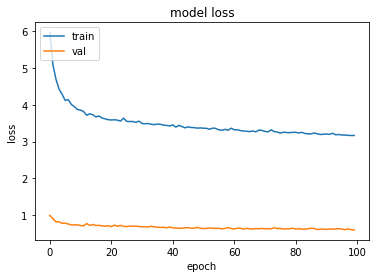

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

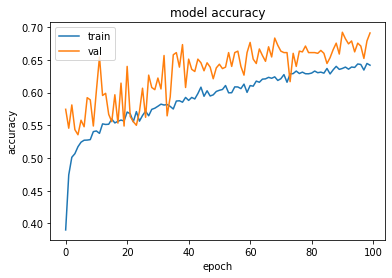

In [20]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [21]:
#model.save("model2.h5")
#from keras.models import load_model
#model = load_model("model2.h5")

### Test

In [22]:
data_test = pd.read_csv('test.csv')
data_test = data_test[data_test.topic == 'cards']

In [23]:
y_test = list()
X_test = list()


for i in tqdm(range(10, 18)):
    X_seq, y_seq = split_sequence(data_test, i, vocab, labels, types, feat, topics, age)
    for x in X_seq:
        X_test.append(x)
    for _y in y_seq:
        y_test.append(_y)
#y_test = np_utils.to_categorical(y_test)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)
X_test = pad_sequences(X_test, value=99)

100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


In [24]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred.argmax(axis=1)))
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
print(matrix)

0.620897320084312
[[954 320 109]
 [352 477 110]
 [272  96 631]]
